## Playing Pong Using Only Pixel Values ft. Policy Gradient

In [1]:
# Import stuff
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Create the environment
env = gym.make("Pong-v0")
env.seed(seed)

n_actions = env.action_space.n
print(n_actions)

6


In [3]:
# A function to grab the current game screen and return it as a 2D numpy array
def get_image(env):
    image = env.render(mode='rgb_array')
    image = image.astype(np.float32) / 255.0  # convert to float and scale to the range [0,1]
    image = np.dot(image, [0.299, 0.587, 0.114])  # convert to grayscale
    return image

In [4]:
# A class for the policy network. Here, we will use a convolutional neural network
# that will take an entire screen of game state and suggest an action from that.
class PolicyNetwork(nn.Module):
    def __init__(self, input_channels=1, input_height=210, input_width=160, output_size=6):
        """Initialize the network"""
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)
        # Can try using pooling layers here
        flat_size = 32 * self.conv2d_size_out(self.conv2d_size_out(input_height, 8, 4), 4, 2) * \
                    self.conv2d_size_out(self.conv2d_size_out(input_width, 8, 4), 4, 2)
        self.fc1 = nn.Linear(flat_size, 256)
        self.fc2 = nn.Linear(256, output_size)
        
    def conv2d_size_out(self, size, kernel_size, stride):
        """Utility function to calculate size of dimension after convolution"""
        return (size - (kernel_size - 1) - 1) // stride + 1
        
    def forward(self, x):
        """Make a forward pass"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [5]:
# A class for the agent
class Agent:
    def __init__(self, learning_rate=0.001, n_actions=6):
        """Initialize agent"""
        self.learning_Rate = learning_rate
        self.n_actions = n_actions
        self.policy = PolicyNetwork().to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
        state = state.to(device)
        probs = self.policy(state)
        action = np.random.choice(self.n_actions, p=probs.to('cpu').detach().squeeze(0).numpy())
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob
    
    def get_probs(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
        state = state.to(device)
        probs = self.policy(state)
        return probs
    
    def update(self, all_rewards, all_log_probs, discount_rate=0.9):
        # Compute discounted rewards
        all_discounted_rewards = []
        for rewards in all_rewards:
            total_reward = 0
            discounted_rewards = [0] * len(rewards)
            for i in reversed(range(len(rewards))):
                discounted_rewards[i] = rewards[i] + discount_rate * total_reward
                total_reward = discounted_rewards[i]
            all_discounted_rewards.append(discounted_rewards)
            
        # Stack all rewards and log probs
        flat_discounted_rewards = [r for rewards in all_discounted_rewards for r in rewards]
        flat_log_probs = [lp for log_probs in all_log_probs for lp in log_probs]
        
        # Convert to tensors
        discounted_rewards = torch.tensor(flat_discounted_rewards).to(device)
        log_probs = torch.stack(flat_log_probs).to(device)
        
        # Normalize rewards, this should speed up training
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Reset parameter gradients
        self.optimizer.zero_grad()
        
        # Compute "loss" function
        loss = torch.mul(discounted_rewards, -log_probs).sum()
        
        # Perform backprop
        loss.backward()
        
        # Optimize
        self.optimizer.step()

In [13]:
# A function to simulate an episode
def simulate(env, agent, render=False, fps=30, max_steps=10000):
    seconds_per_frame = 1 / fps
    total_reward = 0
    env.reset()
    image = get_image(env)
    prev_image = image
    state = image - prev_image
    
    for i in range(max_steps):
        if render:
            env.render()
            time.sleep(seconds_per_frame)
            
        action, log_prob = agent.get_action(state)
        _, reward, done, _ = env.step(action)
        total_reward += reward
        
        if done:
            env.close()
            break
        else:
            prev_image = image
            image = get_image(env)
            state = image - prev_image
            
    print("Simulation complete - total reward:", total_reward)
    return total_reward

In [7]:
# Agent hyperparameters
learning_rate = 0.0001

# Create the agent
agent = Agent(learning_rate)

In [8]:
# Training hyperparameters
n_epochs = 10
episodes_per_epoch = 2
max_steps = 10000
discount_rate = 0.9

# For tracking average rewards
avg_rewards = []

# Option to show the agent in training
show_simulation = False
epoch_per_simulation = 25

# Training loop
for epoch in range(n_epochs):
    all_rewards = []
    all_log_probs = []
    total_reward = 0
    
    for episode in range(episodes_per_epoch):
        rewards = []
        log_probs = []
        
        env.reset()
        image = get_image(env)
        prev_image = image
        state = image - prev_image
        for step in range(max_steps):
            action, log_prob = agent.get_action(state)
            _, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            total_reward += reward
            
            if done:
                break
            else:
                preev_image = image
                image = get_image(env)
                state = image - prev_image
                
        all_rewards.append(rewards)
        all_log_probs.append(log_probs)
        
    # Update the policy
    agent.update(all_rewards, all_log_probs, discount_rate)
    
    # Track average rewards
    avg_rewards.append(total_reward / episodes_per_epoch)
    print("Epoch {}: {}".format(epoch, total_reward / episodes_per_epoch))
    
    # Simulate agent (optional)
    if show_simulation and epoch % epoch_per_simulation == 0:
        simulate(env, agent, render=True)

Epoch 0: -20.5
Epoch 1: -21.0
Epoch 2: -21.0
Epoch 3: -21.0
Epoch 4: -20.0
Epoch 5: -20.0
Epoch 6: -20.5
Epoch 7: -19.5
Epoch 8: -20.5
Epoch 9: -20.5


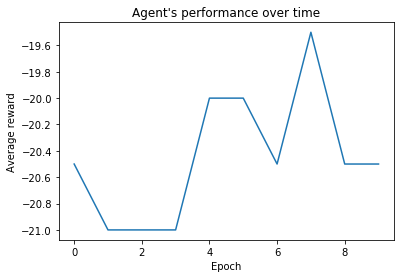

In [11]:
plt.plot(avg_rewards)
plt.title("Agent's performance over time")
plt.xlabel("Epoch")
plt.ylabel("Average reward")
plt.show()

In [12]:
simulate(env, agent, render=True)

NameError: name 'get_state' is not defined